# I. Importing the required libraries

In [1]:
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm.notebook import tqdm

input_duration=3
# % pylab inline

# II. Reading the data

In [2]:
# Data Directory
# Please edit according to your directory change.
dir_list = os.listdir(r'C:\Users\91709\Downloads\4-2\emotion_recognition_cnn-master\data')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [3]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir(r'C:\Users\91709\Downloads\4-2\emotion_recognition_cnn-master\data/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = r'C:\Users\91709\Downloads\4-2\emotion_recognition_cnn-master\data/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [4]:
print (len(data_df))
data_df.head()

1012


,path,source,actor,gender,intensity,statement,repetition,emotion
0,C:\Users\91709\Downloads\4-2\emotion_recogniti...,2,1,male,0,0,0,1
1,C:\Users\91709\Downloads\4-2\emotion_recogniti...,2,1,male,0,0,1,1
2,C:\Users\91709\Downloads\4-2\emotion_recogniti...,2,1,male,0,1,0,1
3,C:\Users\91709\Downloads\4-2\emotion_recogniti...,2,1,male,0,1,1,1
4,C:\Users\91709\Downloads\4-2\emotion_recogniti...,2,1,male,0,0,0,2


# III. Plotting the audio file's waveform and its spectrogram

In [5]:
filename = data_df.path[101]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

C:\Users\91709\Downloads\4-2\emotion_recognition_cnn-master\data/Actor_03/03-02-03-01-01-02-03.wav


(22050,
 array([ 3.83682578e-04,  5.10779093e-04,  5.61281166e-04, ...,
        -1.45874565e-05, -1.68736096e-05,  0.00000000e+00], dtype=float32))

In [6]:
len(samples), sample_rate

(104475, 22050)

In [7]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [8]:
sample_rate/ len(samples)

0.21105527638190955

Text(0.5, 0, 'Seconds')

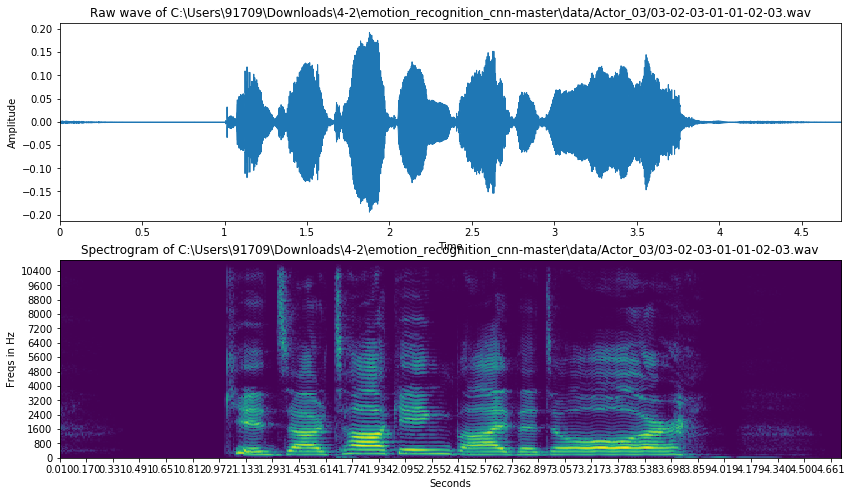

In [9]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [10]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [11]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-1.1219765e-05, -5.1966170e-05,  7.0361966e-07, ...,
        -3.2421103e-04, -5.9854932e-04, -4.4310853e-04], dtype=float32),
 array([22016, 85504]))

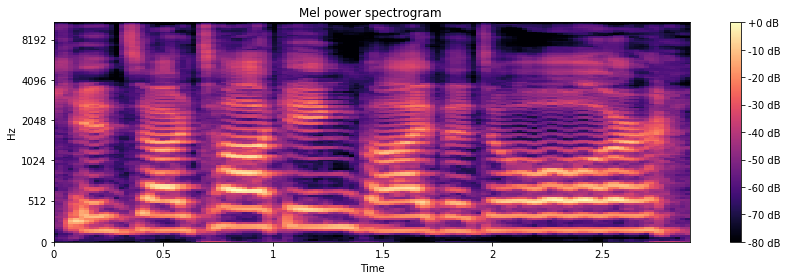

In [12]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

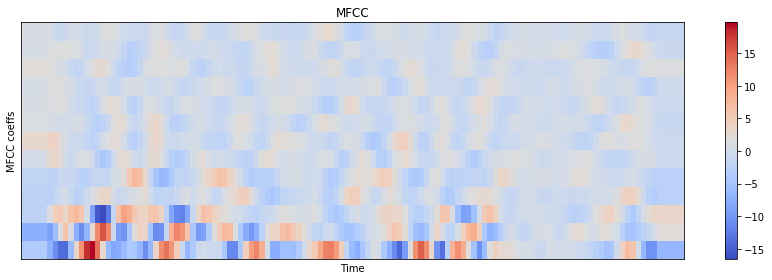

In [13]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [14]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [15]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [16]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

# IV. Defining the truth label

In [17]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

1012

In [18]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

1012

In [19]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

1012

In [20]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1012

In [21]:
# Select the label set you want by commenting the unwanteds.

#data_df['label'] = label2_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C:\Users\91709\Downloads\4-2\emotion_recogniti...,2,1,male,0,0,0,1,male_neutral
1,C:\Users\91709\Downloads\4-2\emotion_recogniti...,2,1,male,0,0,1,1,male_neutral
2,C:\Users\91709\Downloads\4-2\emotion_recogniti...,2,1,male,0,1,0,1,male_neutral
3,C:\Users\91709\Downloads\4-2\emotion_recogniti...,2,1,male,0,1,1,1,male_neutral
4,C:\Users\91709\Downloads\4-2\emotion_recogniti...,2,1,male,0,0,0,2,male_calm


In [22]:
print (data_df.label.value_counts())

male_fearful      96
male_angry        96
male_sad          96
male_calm         96
male_happy        96
female_fearful    88
female_calm       88
female_angry      88
female_happy      88
female_sad        88
male_neutral      48
female_neutral    44
Name: label, dtype: int64


In [23]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

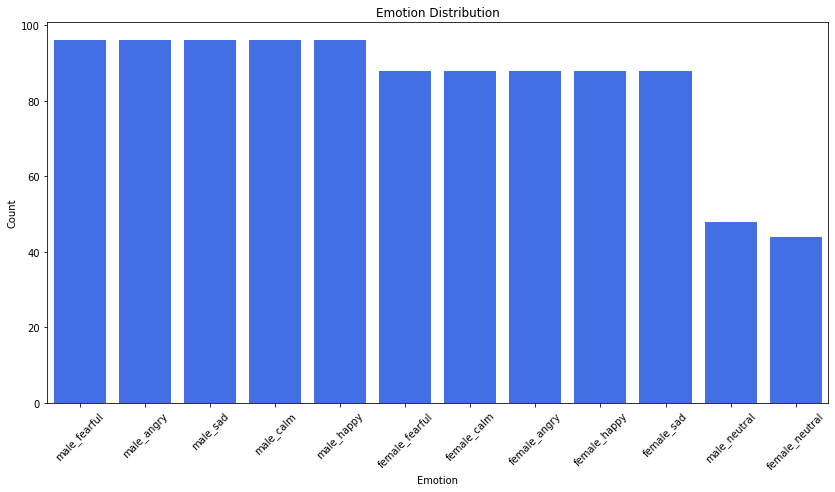

In [24]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

# V. Getting the features of audio files using librosa

In [25]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data_df))):
    X, sample_rate = librosa.load(data_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

In [26]:
data.head()

,feature
0,"[-61.437893, -61.437893, -61.437893, -61.43789..."
1,"[-59.76821, -59.76821, -59.76821, -59.76821, -..."
2,"[-59.419876, -59.419876, -59.419876, -59.41987..."
3,"[-61.265728, -61.265728, -61.265728, -61.26572..."
4,"[-61.542942, -61.67029, -61.663513, -61.675594..."


In [27]:
df2 = pd.DataFrame(data['feature'].values.tolist())
labels = data_df.label

In [28]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,...,-54.355354,-53.183548,-52.159996,-53.495522,-57.154079,-58.150715,-57.935604,-58.245605,-59.881271,-61.311481
1,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,...,-43.190983,-43.408806,-45.088032,-47.333218,-48.194012,-48.874050,-48.956760,-49.640774,-50.328674,-50.369526
2,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,...,-49.856102,-50.825230,-55.782406,-57.036003,-57.068909,-58.142525,-59.376503,-59.419876,-59.419876,-59.292778
3,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,...,-55.630699,-59.486263,-59.140762,-59.598137,-58.535698,-58.505672,-61.139488,-60.459846,-61.265728,-61.265728
4,-61.542942,-61.670292,-61.663513,-61.675594,-59.627464,-58.578274,-60.384644,-60.370815,-59.209068,-59.793682,...,-41.359184,-40.469887,-41.462669,-40.453247,-42.066734,-42.704449,-41.112263,-41.137344,-41.213318,-38.552494


In [29]:
newdf = pd.concat([df2,labels], axis=1)

In [30]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

1012

In [31]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,...,-53.183548,-52.159996,-53.495522,-57.154079,-58.150715,-57.935604,-58.245605,-59.881271,-61.311481,male_neutral
1,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,...,-43.408806,-45.088032,-47.333218,-48.194012,-48.874050,-48.956760,-49.640774,-50.328674,-50.369526,male_neutral
2,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,...,-50.825230,-55.782406,-57.036003,-57.068909,-58.142525,-59.376503,-59.419876,-59.419876,-59.292778,male_neutral
3,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,...,-59.486263,-59.140762,-59.598137,-58.535698,-58.505672,-61.139488,-60.459846,-61.265728,-61.265728,male_neutral
4,-61.542942,-61.670292,-61.663513,-61.675594,-59.627464,-58.578274,-60.384644,-60.370815,-59.209068,-59.793682,...,-40.469887,-41.462669,-40.453247,-42.066734,-42.704449,-41.112263,-41.137344,-41.213318,-38.552494,male_calm
5,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,...,-38.009346,-38.701298,-38.096664,-38.370979,-39.406693,-39.604290,-39.308537,-39.533859,-40.781822,male_calm
6,-61.929478,-61.929478,-61.929478,-61.929478,-60.674362,-60.394733,-61.859238,-61.559097,-61.015480,-59.214947,...,-35.999203,-35.673229,-36.919621,-37.295956,-38.760563,-38.440575,-39.280319,-34.705288,-29.847410,male_calm
7,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.149441,-58.931152,...,-35.757626,-36.504356,-37.956833,-38.763931,-41.045647,-42.594967,-40.545734,-40.981663,-40.627750,male_calm
8,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,...,-33.816696,-33.924683,-34.541080,-34.753689,-36.417641,-36.057072,-35.067146,-27.525869,-20.673979,male_calm
9,-63.557793,-63.707481,-63.975056,-63.975056,-63.975056,-63.975056,-63.975056,-63.975056,-63.975056,-63.975056,...,-39.142540,-40.554661,-40.985573,-41.396805,-40.635559,-40.026054,-40.481163,-39.127335,-34.881783,male_calm


In [32]:
rnewdf.isnull().sum().sum()

0

In [33]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,...,-53.183548,-52.159996,-53.495522,-57.154079,-58.150715,-57.935604,-58.245605,-59.881271,-61.311481,male_neutral
1,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,...,-43.408806,-45.088032,-47.333218,-48.194012,-48.874050,-48.956760,-49.640774,-50.328674,-50.369526,male_neutral
2,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,...,-50.825230,-55.782406,-57.036003,-57.068909,-58.142525,-59.376503,-59.419876,-59.419876,-59.292778,male_neutral
3,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,...,-59.486263,-59.140762,-59.598137,-58.535698,-58.505672,-61.139488,-60.459846,-61.265728,-61.265728,male_neutral
4,-61.542942,-61.670292,-61.663513,-61.675594,-59.627464,-58.578274,-60.384644,-60.370815,-59.209068,-59.793682,...,-40.469887,-41.462669,-40.453247,-42.066734,-42.704449,-41.112263,-41.137344,-41.213318,-38.552494,male_calm


# VI. Data Augmentation

In [34]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data




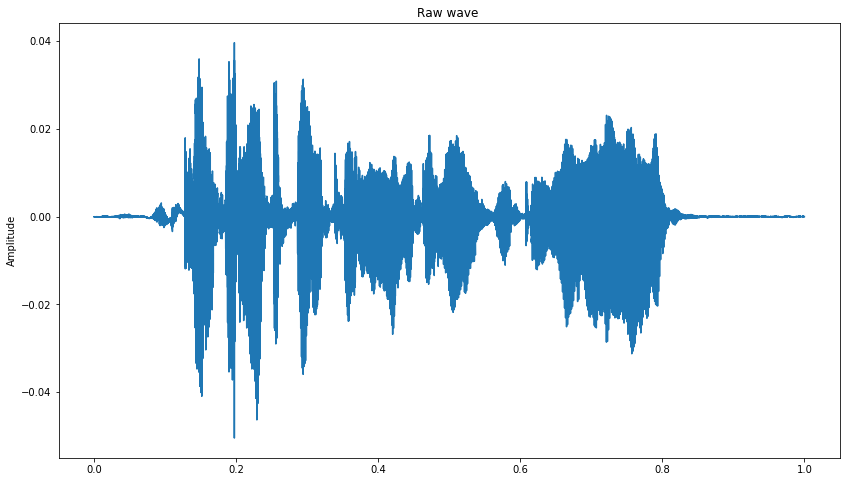

In [35]:
X, sample_rate = librosa.load(data_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

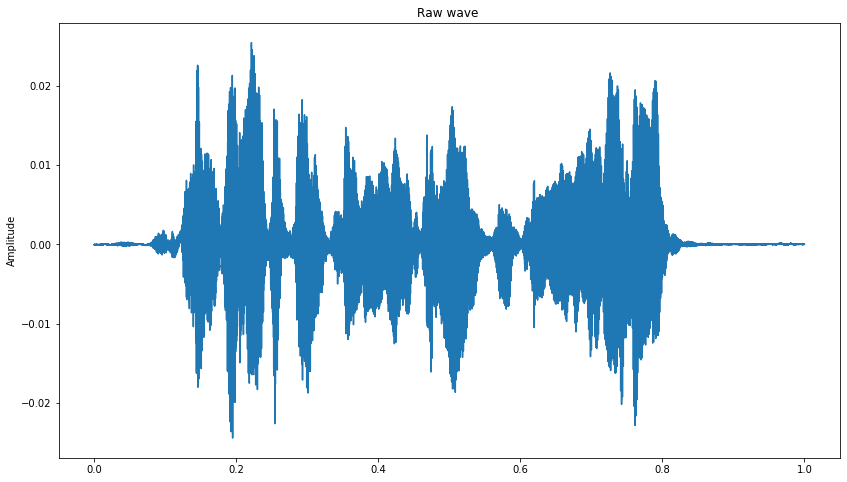

In [36]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [37]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data_df))):
    X, sample_rate = librosa.load(data_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data_df.label[i]]
        

In [38]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data_df))):
    X, sample_rate = librosa.load(data_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data_df.label[i]]
        

In [39]:
len(syn_data1), len(syn_data2) 

(1012, 1012)

In [40]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [41]:
df3 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels3 = syn_data1.label
syndf1 = pd.concat([df3,labels3], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

1012

In [42]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-57.280034,-56.265482,-55.856613,-59.314854,-60.877702,-58.277461,-55.978932,-57.184962,-57.460930,-56.155309,...,-51.667151,-49.836219,-50.205200,-54.078974,-56.145272,-54.422473,-54.424623,-56.896224,-59.449427,male_neutral
1,-47.067623,-45.778808,-45.231624,-46.361339,-49.513799,-49.583590,-48.585961,-47.780377,-47.109792,-46.042339,...,-42.227323,-41.159842,-42.064747,-43.122297,-41.832757,-43.821054,-45.968593,-44.896736,-45.016231,male_neutral
2,-59.429196,-59.420076,-59.260890,-59.420076,-59.416361,-59.420076,-59.375411,-59.420076,-59.426719,-59.420076,...,-50.409447,-55.295962,-57.290042,-57.410331,-57.830836,-59.202225,-59.183444,-59.362449,-59.278437,male_neutral
3,-56.324018,-55.703979,-56.838065,-55.962135,-54.140946,-55.661269,-54.868623,-54.642271,-55.991967,-55.163248,...,-57.134618,-55.857106,-54.451508,-54.487782,-55.791011,-57.804047,-57.431204,-54.258292,-54.673254,male_neutral
4,-58.597823,-58.458552,-56.530627,-56.604713,-56.648927,-55.700707,-58.591819,-58.504760,-56.468356,-55.166195,...,-39.863533,-40.632324,-39.961943,-41.591459,-42.092436,-40.627914,-40.526777,-40.266113,-38.274347,male_calm


In [43]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

1012

In [44]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-63.660003,-63.660003,-63.660003,-63.660003,-63.660003,-63.660003,-63.660003,-63.660003,-63.660003,-63.660003,...,-54.357872,-53.958423,-55.837216,-58.030659,-59.746098,-59.890370,-59.561400,-61.280018,-63.214301,male_neutral
1,-61.235095,-61.235095,-61.235095,-61.235095,-61.235095,-61.235095,-61.235095,-61.235095,-61.235095,-61.235095,...,-47.695161,-48.512855,-50.562615,-51.714891,-53.738851,-52.825136,-52.635906,-52.025123,-52.292995,male_neutral
2,-62.975477,-62.975477,-62.975477,-62.975477,-62.975477,-62.975477,-62.975477,-62.975477,-62.975477,-62.975477,...,-56.742573,-59.162913,-60.721358,-61.505384,-61.008798,-61.844304,-62.881180,-62.975477,-62.975477,male_neutral
3,-61.701228,-61.701228,-61.701228,-61.701228,-61.701228,-61.701228,-61.701228,-61.701228,-61.701228,-61.701228,...,-60.701693,-60.786863,-60.239491,-60.602402,-61.555126,-61.412064,-61.710476,-61.701228,-61.701228,male_neutral
4,-62.913745,-63.393686,-63.353878,-62.862693,-61.814354,-60.640272,-60.736628,-62.017674,-61.528561,-61.601420,...,-47.850437,-49.579838,-49.117215,-48.548764,-48.306489,-47.353487,-46.301960,-46.235267,-45.171881,male_calm


In [45]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,...,-53.183548,-52.159996,-53.495522,-57.154079,-58.150715,-57.935604,-58.245605,-59.881271,-61.311481,male_neutral
1,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,-59.768211,...,-43.408806,-45.088032,-47.333218,-48.194012,-48.874050,-48.956760,-49.640774,-50.328674,-50.369526,male_neutral
2,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,-59.419876,...,-50.825230,-55.782406,-57.036003,-57.068909,-58.142525,-59.376503,-59.419876,-59.419876,-59.292778,male_neutral
3,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,-61.265728,...,-59.486263,-59.140762,-59.598137,-58.535698,-58.505672,-61.139488,-60.459846,-61.265728,-61.265728,male_neutral
4,-61.542942,-61.670292,-61.663513,-61.675594,-59.627464,-58.578274,-60.384644,-60.370815,-59.209068,-59.793682,...,-40.469887,-41.462669,-40.453247,-42.066734,-42.704449,-41.112263,-41.137344,-41.213318,-38.552494,male_calm


In [46]:
#  Stratified Shuffle Split
from sklearn.model_selection import StratifiedShuffleSplit
X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [47]:
y_train.shape

(2428,)

In [48]:
y_train.value_counts()

male_angry        231
male_calm         231
male_fearful      230
male_sad          230
male_happy        230
female_fearful    211
female_calm       211
female_angry      211
female_happy      211
female_sad        211
male_neutral      115
female_neutral    106
Name: label, dtype: int64

In [49]:
y_train.shape

(2428,)

In [50]:
y_test.value_counts()

male_fearful      58
male_sad          58
male_happy        58
male_calm         57
male_angry        57
female_sad        53
female_fearful    53
female_calm       53
female_angry      53
female_happy      53
male_neutral      29
female_neutral    26
Name: label, dtype: int64

In [51]:
X_train.isna().sum().sum()

0

In [52]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
#lb = LabelEncoder()
#y_train = np_utils.to_categorical(lb.fit_transform(y_train))
#y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [53]:
y_train

array(['female_angry', 'male_angry', 'female_calm', ..., 'female_sad',
       'female_happy', 'male_calm'], dtype=object)

In [54]:
X_train.shape

(2428, 259)

In [55]:
y_train.shape

(2428,)

# VII. XGBoost model

In [80]:
import xgboost as xgb

In [81]:
xgb_clf = xgb.XGBClassifier(max_depth=3,n_estimators=300,learning_rate=0.05)

In [82]:
xgb_clf.fit(X_train,y_train)

C:\Users\91709\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[15:19:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [83]:
y_predict = xgb_clf.predict(X_test)

In [84]:
confusion_matrix(y_test,y_predict)

array([[45,  2,  3,  3,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 37,  0,  6,  1,  9,  0,  0,  0,  0,  0,  0],
       [ 4,  2, 30, 10,  1,  3,  0,  0,  2,  1,  0,  0],
       [ 6,  3,  4, 39,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 1,  6,  2,  3,  5,  9,  0,  0,  0,  0,  0,  0],
       [ 1, 13,  4,  3,  2, 30,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 38,  1,  8,  7,  0,  3],
       [ 0,  0,  1,  0,  1,  0,  0, 38,  0,  4,  1, 12],
       [ 1,  0,  0,  0,  0,  0,  5,  4, 34,  6,  4,  4],
       [ 0,  0,  0,  0,  0,  0,  4,  3,  5, 37,  6,  3],
       [ 0,  0,  1,  0,  0,  0,  0,  6,  5,  5,  7,  5],
       [ 0,  2,  0,  0,  0,  1,  3,  7,  1,  2,  2, 40]], dtype=int64)

In [85]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_predict)*100

62.5

In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predict,target_names=["0","1","2","3","4","5","6","7","8","9","10","11"]))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81        53
           1       0.57      0.70      0.63        53
           2       0.67      0.57      0.61        53
           3       0.61      0.74      0.67        53
           4       0.50      0.19      0.28        26
           5       0.57      0.57      0.57        53
           6       0.76      0.67      0.71        57
           7       0.64      0.67      0.66        57
           8       0.62      0.59      0.60        58
           9       0.60      0.64      0.62        58
          10       0.35      0.24      0.29        29
          11       0.60      0.69      0.64        58

    accuracy                           0.62       608
   macro avg       0.60      0.59      0.59       608
weighted avg       0.62      0.62      0.62       608



In [87]:
from sklearn.metrics import f1_score
f1_score(y_test, y_predict, average='macro') *100

58.918834872012894

In [88]:
y_predict

array(['female_angry', 'female_calm', 'male_fearful', 'male_fearful',
       'female_fearful', 'male_neutral', 'male_angry', 'female_happy',
       'male_calm', 'male_happy', 'male_sad', 'female_happy',
       'male_fearful', 'female_sad', 'female_calm', 'male_happy',
       'female_calm', 'female_neutral', 'male_sad', 'male_calm',
       'male_fearful', 'female_neutral', 'female_fearful',
       'female_fearful', 'male_angry', 'male_happy', 'female_happy',
       'male_fearful', 'female_calm', 'male_fearful', 'male_fearful',
       'male_happy', 'female_happy', 'male_happy', 'female_calm',
       'male_angry', 'male_fearful', 'male_sad', 'male_happy',
       'female_happy', 'female_angry', 'female_happy', 'male_angry',
       'female_fearful', 'female_angry', 'female_calm', 'male_calm',
       'female_calm', 'male_calm', 'male_calm', 'female_calm',
       'female_calm', 'male_sad', 'female_happy', 'male_angry',
       'male_happy', 'female_calm', 'male_sad', 'male_calm', 'male_angry',

In [89]:
preddf = pd.DataFrame({'predictedvalues': y_predict})
preddf[:10]

,predictedvalues
0,female_angry
1,female_calm
2,male_fearful
3,male_fearful
4,female_fearful
5,male_neutral
6,male_angry
7,female_happy
8,male_calm
9,male_happy


In [90]:
actualdf = pd.DataFrame({'Actualvalues': y_test})
actualdf[:10]

,Actualvalues
0,female_angry
1,female_calm
2,male_fearful
3,male_fearful
4,female_fearful
5,male_neutral
6,male_angry
7,female_happy
8,male_calm
9,male_happy


In [91]:
finaldf = actualdf.join(preddf)

In [92]:
finaldf[20:40]

,Actualvalues,predictedvalues
20,male_fearful,male_fearful
21,female_calm,female_neutral
22,female_neutral,female_fearful
23,male_neutral,female_fearful
24,male_angry,male_angry
25,male_angry,male_happy
26,female_happy,female_happy
27,male_fearful,male_fearful
28,female_calm,female_calm
29,male_fearful,male_fearful


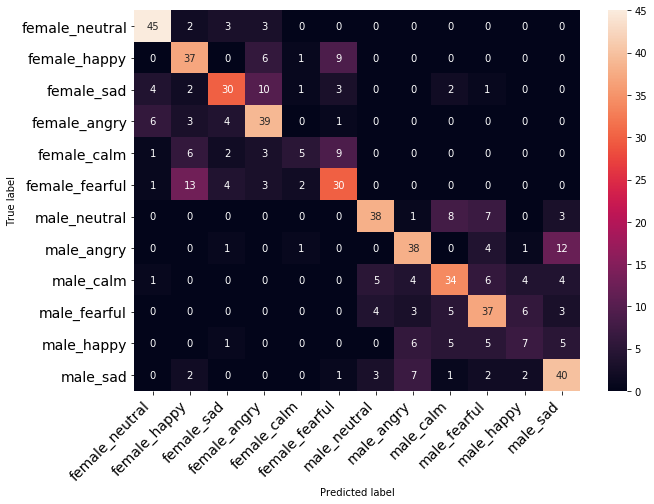

In [93]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_test, y_predict)
c
class_names = ['female_neutral', 'female_happy','female_sad','female_angry','female_calm','female_fearful','male_neutral','male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
print_confusion_matrix(c, class_names)

In [94]:
finaldf.groupby('predictedvalues').count()

,Actualvalues
predictedvalues,
female_angry,58
female_calm,65
female_fearful,45
female_happy,64
female_neutral,10
female_sad,53
male_angry,50
male_calm,59
male_fearful,55


# Soft Voting Ensemble Model

In [95]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [96]:
rfClf = RandomForestClassifier(n_estimators=500, random_state=0) # 500 trees. 
svmClf = SVC(probability=True, random_state=0) # probability calculation
logClf = LogisticRegression(random_state=0)

In [97]:
clf2 = VotingClassifier(estimators = [('rf',rfClf), ('svm',svmClf), ('log', logClf)], voting='soft')

In [98]:
clf2.fit(X_train, y_train)

C:\Users\91709\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=500,
                                                     random_state=0)),
                             ('svm', SVC(probability=True, random_state=0)),
                             ('log', LogisticRegression(random_state=0))],
                 voting='soft')

In [99]:
y_predict = clf2.predict(X_test)

In [100]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [101]:
confusion_matrix(y_test,y_predict)

array([[40,  1,  3,  6,  0,  2,  0,  0,  0,  1,  0,  0],
       [ 0, 42,  1,  1,  3,  6,  0,  0,  0,  0,  0,  0],
       [ 8,  0, 28,  8,  0,  7,  0,  0,  1,  0,  1,  0],
       [ 7,  2,  4, 31,  0,  9,  0,  0,  0,  0,  0,  0],
       [ 0,  5,  3,  1, 10,  7,  0,  0,  0,  0,  0,  0],
       [ 2, 13,  6,  1,  4, 27,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 38,  2,  9,  7,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  3, 39,  1,  2,  1, 11],
       [ 1,  1,  1,  0,  0,  0,  9,  3, 33,  3,  1,  6],
       [ 0,  0,  0,  0,  0,  0,  5,  2,  6, 40,  4,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  8,  4,  7,  7,  3],
       [ 1,  1,  0,  0,  0,  0,  8, 10,  2,  1,  1, 34]], dtype=int64)

In [102]:
accuracy_score(y_test,y_predict)*100

60.69078947368421

In [103]:
print(classification_report(y_test,y_predict,target_names=["0","1","2","3","4","5","6","7","8","9","10","11"]))

              precision    recall  f1-score   support

           0       0.68      0.75      0.71        53
           1       0.65      0.79      0.71        53
           2       0.61      0.53      0.57        53
           3       0.65      0.58      0.61        53
           4       0.59      0.38      0.47        26
           5       0.47      0.51      0.49        53
           6       0.60      0.67      0.63        57
           7       0.61      0.68      0.64        57
           8       0.59      0.57      0.58        58
           9       0.66      0.69      0.67        58
          10       0.47      0.24      0.32        29
          11       0.61      0.59      0.60        58

    accuracy                           0.61       608
   macro avg       0.60      0.58      0.58       608
weighted avg       0.60      0.61      0.60       608



In [104]:
preddf = pd.DataFrame({'predictedvalues': y_predict})
preddf[:10]

,predictedvalues
0,female_angry
1,female_calm
2,male_fearful
3,male_fearful
4,female_sad
5,male_neutral
6,male_angry
7,female_happy
8,male_sad
9,male_happy


In [105]:
actualdf = pd.DataFrame({'Actualvalues': y_test})
actualdf[:10]

,Actualvalues
0,female_angry
1,female_calm
2,male_fearful
3,male_fearful
4,female_fearful
5,male_neutral
6,male_angry
7,female_happy
8,male_calm
9,male_happy


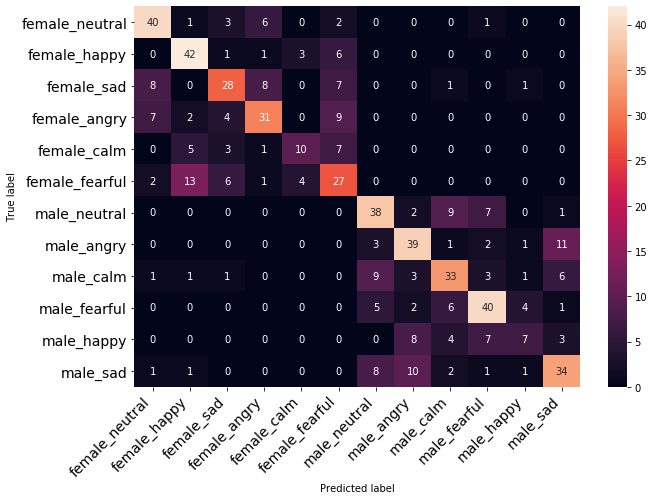

In [106]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_test, y_predict)
c
class_names = ['female_neutral', 'female_happy','female_sad','female_angry','female_calm','female_fearful','male_neutral','male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
print_confusion_matrix(c, class_names)